In [ ]:
from shapely.geometry import *
from shapely.wkt import loads
# from shapely import LineString, MultiPoint
# from shapely.ops import nearest_points, split, snap, unary_union

import contextily as cx
import earthaccess
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import xarray as xr
# import shapely

### Read in and prep NHD

In [ ]:
## Set-up
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
prep_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/'

In [ ]:
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# Read in HUC lookup table
lookup = pd.read_csv(os.path.join(mdata_path, 'HUC4_lookup_no_great_lakes.csv'), dtype=dtype_dic)

In [ ]:
# Get slurm job index
i = 4 # HUC4 0108

# Get current HUC2 and HUC4 IDs
hu2 = 'HUC2_' + lookup.loc[i,'HUC4'][0:2]
hu4 = 'NHDPLUS_H_' + lookup.loc[i,'HUC4'] + '_HU4_GDB'

In [ ]:
# Set data filepath
file_path = os.path.join(prep_path, hu2, hu4 + '_prepped.gpkg')

In [ ]:
# Read in NHD flowlines
features = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'Bin', 'geometry']
basin = gpd.read_file(filename=file_path, columns=features, engine='pyogrio')

In [ ]:
# Drop reaches that are shorter than their width
basin = basin[basin['LengthKM']*1000 > basin['WidthM']]

#### Read in Pixel Cloud

##### Download (one-time)

In [25]:
# 341_229R
pixc_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                       temporal = ('2024-04-01 00:00:00', '2024-08-01 23:59:59'),
                                       granule_name = '*_341_229R_*') # Fort River/Cushman Brook

In [26]:
# leaf off
earthaccess.download(pixc_results[0], '../data/small_rivers/mar_2024_ver_c/')

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1024.00it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:18<00:00, 18.94s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12748.64it/s]


['../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_013_341_229R_20240408T184449_20240408T184500_PIC0_01.nc']

In [24]:
# leaf on
earthaccess.download(pixc_results[-1], '../data/small_rivers/mar_2024_ver_c/')

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1700.16it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:12<00:00, 12.69s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 12087.33it/s]


['../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_018_341_229R_20240722T023012_20240722T023023_PIC0_01.nc']

In [27]:
# 298_080L
pixc_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                       temporal = ('2024-04-01 00:00:00', '2024-08-01 23:59:59'),
                                       granule_name = '*_298_080L_*') # Fort River/Cushman Brook

In [28]:
# leaf off
earthaccess.download(pixc_results[0], '../data/small_rivers/mar_2024_ver_c/')

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1632.66it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:21<00:00, 21.23s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 13148.29it/s]


['../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_013_298_080L_20240407T052741_20240407T052752_PIC0_01.nc']

In [29]:
# leaf on
earthaccess.download(pixc_results[-1], '../data/small_rivers/mar_2024_ver_c/')

QUEUEING TASKS | : 100%|██████████| 1/1 [00:00<00:00, 1700.16it/s]
PROCESSING TASKS | : 100%|██████████| 1/1 [00:14<00:00, 14.29s/it]
COLLECTING RESULTS | : 100%|██████████| 1/1 [00:00<00:00, 4161.02it/s]


['../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_018_298_080L_20240720T131306_20240720T131317_PIC0_03.nc']

##### Read in

In [32]:
filepath = '../data/small_rivers/mar_2024_ver_c/*_PIXC_018_298_080L_*'

In [33]:
ds_PIXC = xr.open_mfdataset(filepath, group = 'pixel_cloud', engine='h5netcdf')

In [34]:
ds_PIXC

<xarray.Dataset> Size: 1GB
Dimensions:                                (points: 4776422, complex_depth: 2,
                                            num_pixc_lines: 3266)
Coordinates:
    latitude                               (points) float64 38MB dask.array<chunksize=(477643,), meta=np.ndarray>
    longitude                              (points) float64 38MB dask.array<chunksize=(477643,), meta=np.ndarray>
Dimensions without coordinates: points, complex_depth, num_pixc_lines
Data variables: (12/61)
    azimuth_index                          (points) float64 38MB dask.array<chunksize=(955285,), meta=np.ndarray>
    range_index                            (points) float64 38MB dask.array<chunksize=(955285,), meta=np.ndarray>
    interferogram                          (points, complex_depth) float32 38MB dask.array<chunksize=(1194106, 1), meta=np.ndarray>
    power_plus_y                           (points) float32 19MB dask.array<chunksize=(955285,), meta=np.ndarray>
    power_minus_y                          (points) float32 19MB dask.array<chunksize=(955285,), meta=np.ndarray>
    coherent_power                         (points) float32 19MB dask.array<chunksize=(955285,), meta=np.ndarray>
    ...                                     ...
    pixc_line_qual                         (num_pixc_lines) float64 26kB dask.array<chunksize=(3266,), meta=np.ndarray>
    pixc_line_to_tvp                       (num_pixc_lines) float32 13kB dask.array<chunksize=(3266,), meta=np.ndarray>
    data_window_first_valid                (num_pixc_lines) float64 26kB dask.array<chunksize=(3266,), meta=np.ndarray>
    data_window_last_valid                 (num_pixc_lines) float64 26kB dask.array<chunksize=(3266,), meta=np.ndarray>
    data_window_first_cross_track          (num_pixc_lines) float32 13kB dask.array<chunksize=(3266,), meta=np.ndarray>
    data_window_last_cross_track           (num_pixc_lines) float32 13kB dask.array<chunksize=(3266,), meta=np.ndarray>
Attributes:
    description:                 cloud of geolocated interferogram pixels
    interferogram_size_azimuth:  3266
    interferogram_size_range:    4694
    looks_to_efflooks:           1.544864133704729
    num_azimuth_looks:           7.0
    azimuth_offset:              7

##### Flag exploration

In [35]:
pre_mask = np.where(ds_PIXC.classification > 1)[0].tolist()

In [36]:
# Excluding layover_impact as it is is only useful for aggregated heights
variables = ['azimuth_index', 'range_index', 'water_frac', 'water_frac_uncert',
             'classification', 'false_detection_rate', 'missed_detection_rate',
             'prior_water_prob', 'bright_land_flag', 'height', 'geoid',
             'ancillary_surface_classification_flag', 'interferogram_qual',
             'classification_qual', 'geolocation_qual', 'sig0_qual']

In [37]:
d = {}
for var in variables:
    d[var] = ds_PIXC[var][pre_mask]

In [38]:
# # Make GeoDataFrame
# gdf = gpd.GeoDataFrame(data=d, index=range(len(gq)),
#                         geometry=gpd.points_from_xy(ds_PIXC.longitude,
#                                                     ds_PIXC.latitude))

# Make DataFrame
df = pd.DataFrame(data=d, index=range(len(pre_mask)))

In [39]:
np.set_printoptions(suppress=True)
np.unique(df.geolocation_qual)

array([     0.,      1.,      2.,      3.,      4.,      5.,      6.,
            7.,   4096.,   4097.,   4098.,   4099.,   4100.,   4101.,
         4102.,   4103., 524288., 524289., 524292., 524293., 524294.,
       524295., 528384., 528388., 528389., 528390.])

In [40]:
counts = df.geolocation_qual.value_counts().sort_index()
counts

geolocation_qual
0.0         479472
1.0          25289
2.0            155
3.0             61
4.0         546247
5.0          80696
6.0            477
7.0            187
4096.0         124
4097.0          27
4098.0          13
4099.0           1
4100.0       16174
4101.0        2696
4102.0          12
4103.0           3
524288.0      6474
524289.0       498
524292.0     56522
524293.0      2791
524294.0       144
524295.0         8
528384.0         4
528388.0      1149
528389.0        75
528390.0         1
Name: count, dtype: int64

##### Mask

In [117]:
# We only want to allow pixels with layover_significant or 
# phase_noise_suspect, but so many pixels have xovercal_suspect
# this will keep those that have xovercal_suspect and/or
# layover_significant and/or phase_noise_suspect
flags = np.logical_or.reduce([ds_PIXC.geolocation_qual < 4, 
                                ds_PIXC.geolocation_qual == 64,
                                ds_PIXC.geolocation_qual == 65,
                                ds_PIXC.geolocation_qual == 66,
                                ds_PIXC.geolocation_qual == 67])

# Keep pixels where class is not land and flag is one of the above
# mask = np.where(np.logical_and(ds_PIXC.classification > 1, flags))[0]
mask = np.where(ds_PIXC.classification > 1)[0]

In [118]:
gdf_PIXC = gpd.GeoDataFrame(ds_PIXC.classification[mask],
                        geometry=gpd.points_from_xy(ds_PIXC.longitude[mask],
                                                    ds_PIXC.latitude[mask]),
                        crs="EPSG:4326")
gdf_PIXC.rename(columns={gdf_PIXC.columns[0]: 'klass'}, inplace=True)
gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)

#### For now: Get bounds of PIXC and crop basin to it

In [119]:
# Get bounds of PIXC, construct polygon
bounds_PIXC = gdf_PIXC.total_bounds
poly = box(bounds_PIXC[0], bounds_PIXC[1], bounds_PIXC[2], bounds_PIXC[3])

In [120]:
crop_basin = basin.clip(poly)

In [121]:
bins = np.unique(crop_basin.Bin)
bins

array(['(0, 10]', '(10, 20]', '(150, 200]', '(20, 30]', '(200, 500]',
       '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]'], dtype=object)

#### Sjoin

In [123]:
# Reaches for PTs
reach_id = 10000900004534
# reaches = [10000900091444, 10000900091445, 10000900054636,
#            10000900042171, 10000900005063, 10000900054639,
#            10000900017746, 10000900079646]
# This is the beaver marsh: 10000900042169, 10000900029899, 10000900079371

In [124]:
reach = basin.loc[basin['NHDPlusID'] == reach_id]
reach

,Bin,GNIS_Name,LengthKM,NHDPlusID,WidthM,geometry
3020,"(20, 30]",Fort River,1.512,1.000090e+13,22.69987,MULTILINESTRING Z ((-8073669.137 5212376.643 0...


In [125]:
# Buffer reach by 1/2 channel width
reach['geometry'] = reach.geometry.buffer(distance=(reach.WidthM/2), cap_style='flat')

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [126]:
inside = gpd.sjoin(gdf_PIXC, reach, how='inner', predicate='within').rename(columns={'index_right': 'segment'})

In [127]:
np.unique(inside.klass)

array([2., 3., 6.], dtype=float32)

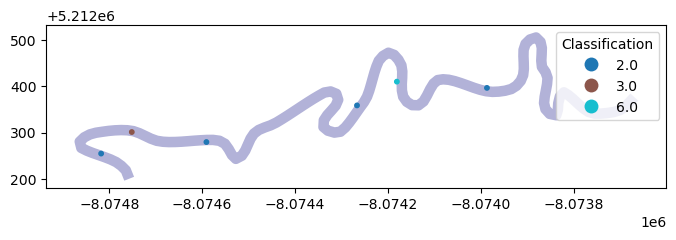

In [132]:
fig, ax = plt.subplots(figsize=(8,8))
reach.plot(cmap='jet', alpha=0.3, ax=ax)
inside.plot(column=inside.klass, categorical=True, 
            markersize=10, c=inside.klass, ax=ax, legend=True)

leg1 = ax.get_legend()
leg1.set_title("Classification")